# Исследование и прогноз надежности заемщиков

Задача -- необходимо установить признаки, влияющие на факт погашения кредита в срок (проанализировать от чего заисит debt).
Построить модель, предсказывающую вероятность невозврата кредита

Описание данных

|Признак|Описание|
|--:|:--|
|children | количество детей в семье|
|days_employed | общий трудовой стаж в днях|
|dob_years | возраст клиента в годах|
|education | уровень образования клиента|
|education_id | идентификатор уровня образования|
|family_status | семейное положение|
|family_status_id | идентификатор семейного положения|
|gender | пол клиента|
|income_type | тип занятости|
|debt | имел ли задолженность по возврату кредитов|
|total_income | ежемесячный доход|
|purpose | цель получения кредита|


In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
df = pd.read_csv('bank.csv')

In [105]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


# Предобработка

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [107]:
df.isna().mean()

children            0.000000
days_employed       0.100999
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

Видим прорущенные значения в признаках days_employed и total_income по 10% в каждом

In [108]:
df.duplicated().sum()

54

In [109]:
df.drop_duplicates(inplace=True)

Удалили дубликаты из таблицы 

In [110]:
percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99] 
df.describe(percentiles = percentiles) 

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21471.000000,19351.000000,21471.000000,21471.000000,21471.000000,21471.000000,1.935100e+04
mean,0.539565,63046.497661,43.279074,0.817195,0.973685,0.081086,1.674223e+05
std,1.382978,140827.311974,12.574291,0.548508,1.421082,0.272974,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
1%,0.000000,-10697.267671,21.000000,0.000000,0.000000,0.000000,4.365679e+04
5%,0.000000,-6622.968349,25.000000,0.000000,0.000000,0.000000,6.332285e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
90%,2.000000,360310.974923,60.000000,1.000000,4.000000,0.000000,2.784149e+05


#### Обрабатываем аномальные значения

Обработка признака children

In [111]:
df.groupby('children')['debt'].agg(['count', 'mean'])

,count,mean
children,,
-1,47,0.021277
0,14107,0.075353
1,4809,0.092327
2,2052,0.094542
3,330,0.081818
4,41,0.097561
5,9,0.000000
20,76,0.105263


Заменяем -1 на 1, 20 на медианное значение

In [112]:
df.children = df.children.replace(-1, 1)
df.children = df.children.replace(20, df.children.median())

Обработка признака days_employed

In [113]:
def to_positive(val):
    if val < 0:
        val *= -1
    return val

In [114]:
df.days_employed = df.days_employed.apply(to_positive)

Создали функцию по замене отрицательных значений на положительные и применили ее к признаку days_employed

<Axes: >

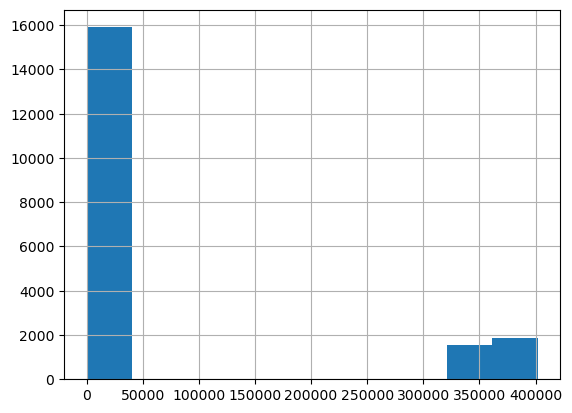

In [115]:
df.days_employed.hist()

In [116]:
days_empl_med_f = df[df['gender']=='F'].days_employed.median()
days_empl_med_m = df[df['gender']=='M'].days_employed.median()
days_empl_med_f, days_empl_med_m

(2539.8568941574986, 1662.3701026212125)

In [117]:
df.loc[(df['days_employed'] > 30000) & (df['gender']=='F'), 'days_employed'] = days_empl_med_f
df.loc[(df['days_employed'] > 30000) & (df['gender']=='M'), 'days_employed'] = days_empl_med_m

In [118]:
df.days_employed.median()

1959.556497607566

In [119]:
df.days_employed.describe()

count    19351.000000
mean      2357.348036
std       2094.044439
min         24.141633
25%        927.009265
50%       1959.556498
75%       2747.423625
max      18388.949901
Name: days_employed, dtype: float64

В признаке days_employed заменили отрицательные значения на положительные.
    В столбце присутствует большое количество крайне аномальных (невозможных) значении (более 300 000 дней стажа). Что сильно повлияет на дальнейший анализ. На практике, лучше всего было бы сходить к операторам, которые вносили данные, узнать с чем связана ошибка. В текущих условиях, заменили аномальные значения по медианной с разбиением по гендеру.
  Аналогично и с пропущенными значениями признака days_employed

Обработка признака dob_years

In [120]:
df.query('dob_years == 0').dob_years.count()

101

In [121]:
df = df[df['dob_years'] != 0]

Удалили строки со значеним возраста клиента = 0

Обработка признака education

In [122]:
df.education.unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [123]:
df.education = df.education.str.lower()

Привели все значения признака к нижнему регистру

Обработка признака education

In [124]:
df.gender.unique()

array(['F', 'M', 'XNA'], dtype=object)

In [125]:
df.query('gender == "XNA"').gender.count()

1

In [126]:
df = df[df['gender'] != "XNA"]

Удалили строку с неизвестным значением пола

Обработка признака total_income

In [127]:
total_income_median = df['total_income'].median()

In [128]:
df['total_income'] = df['total_income'].fillna(total_income_median)

In [129]:
df['total_income'] = df['total_income'].astype('int')

In [130]:
df['total_income'].median()

145005.0

Заменили пропущенные значения доходов на медианное

# Анализ

In [131]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,2539.856894,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


In [132]:
df['dob_years_group'] = pd.qcut(df.dob_years, 5)

In [133]:
df.groupby('dob_years_group')['debt'].agg(['count', 'mean'])

,count,mean
dob_years_group,,
"(18.999, 31.0]",4277,0.111994
"(31.0, 39.0]",4566,0.092422
"(39.0, 47.0]",4313,0.078600
"(47.0, 56.0]",4352,0.065717
"(56.0, 75.0]",3861,0.053613


<Axes: xlabel='dob_years_group'>

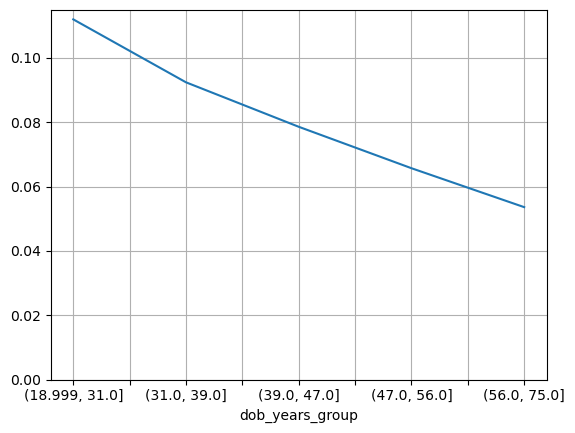

In [134]:
df.groupby('dob_years_group')['debt'].mean().plot(ylim=0, grid=True)

Люди молодого возраста являются самыми рискованными заемщиками. С возрастом, надежность повышается

In [135]:
df.groupby('gender')['debt'].agg(['count', 'mean'])

,count,mean
gender,,
F,14117,0.070057
M,7252,0.102592


Видим перекос по количесву кредитов в сторону женщин (в 2 раза больше), причем процент должников среди мужчин на 3.2% выше. Возможно влияние другой переменной.

In [136]:
df.groupby('gender')['dob_years'].agg(['count', 'mean', 'median'])

,count,mean,median
gender,,,
F,14117,44.684919,44.0
M,7252,41.147821,40.0


 В среднем, возраст мужчин ниже, чем у женщин. Но при этом, они все равно относятся к одной возрастной группе из анализа выше.

In [137]:
df.groupby('gender')['days_employed'].agg(['count', 'mean', 'median'])

,count,mean,median
gender,,,
F,12688,2523.649490,2539.856894
M,6571,2037.664074,1662.370103


In [138]:
df.groupby('gender')['total_income'].agg(['count', 'mean', 'median'])

,count,mean,median
gender,,,
F,14117,153228.070695,143501.0
M,7252,188638.520270,159004.0


Стаж мужчин в нашей выборке ниже, чем у женщин, но при этом доходы выше

In [139]:
df.groupby(['dob_years_group', 'gender'])['debt'].agg(['count', 'mean'])

count      mean
dob_years_group gender                 
(18.999, 31.0]  F        2500  0.102400
                M        1777  0.125492
(31.0, 39.0]    F        2793  0.087361
                M        1773  0.100395
(39.0, 47.0]    F        2798  0.066476
                M        1515  0.100990
(47.0, 56.0]    F        3082  0.053212
                M        1270  0.096063
(56.0, 75.0]    F        2944  0.047215
                M         917  0.074155

У мужчин и женщин картина по возврату долгов с возрастом улучшается .Женщины во всех возрастных группах являются более надежными плательщиками. При чем разрыв в возрате займа между полами растет с возрастом  

In [140]:
df.groupby('education')['debt'].agg(['count', 'mean'])

,count,mean
education,,
высшее,5216,0.053106
начальное,282,0.109929
неоконченное высшее,741,0.091768
среднее,15124,0.089725
ученая степень,6,0.000000


Видим, что люди с высшим образованием имеют самый низкий процент по наличию просрочек платежей, а люди с начальным - самы высокий

In [141]:
df['total_income_group'] = pd.cut(df['total_income'], bins=[0, 40000, 70000, 120000, 150000, 200000, 300000, float('inf')])

In [142]:
df.groupby('total_income_group')['debt'].agg(['count', 'mean'])

,count,mean
total_income_group,,
"(0.0, 40000.0]",124,0.080645
"(40000.0, 70000.0]",1345,0.067658
"(70000.0, 120000.0]",5339,0.083724
"(120000.0, 150000.0]",5424,0.085361
"(150000.0, 200000.0]",4098,0.089068
"(200000.0, 300000.0]",3561,0.070486
"(300000.0, inf]",1478,0.071719


<Axes: xlabel='total_income_group'>

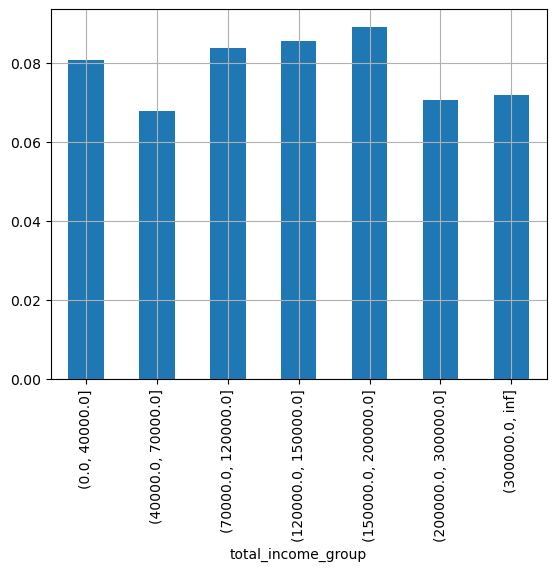

In [143]:
df.groupby('total_income_group')['debt'].mean().plot(grid=True, kind='bar')

Видим интересную картину, люди с невысоким доходом (40к-70к) имеют наименьшее количество просрочек по кредитам, затем по надежности идут граждане с наибольшими доходами (200к+)

In [144]:
df.groupby('children')['debt'].agg(['count', 'mean'])

,count,mean
children,,
0,14112,0.075539
1,4840,0.091322
2,2039,0.095145
3,328,0.082317
4,41,0.097561
5,9,0.000000


Людей с 5 детьми чрезмерно мало, поэтому игнорируем как шум. Картинка складывается следующая: наиболее надежныен заемщики - люди без детей

In [145]:
df['days_employed_group'] = pd.qcut(df.days_employed, 5)

In [146]:
df.groupby('days_employed_group')['debt'].agg(['count', 'mean'])

,count,mean
days_employed_group,,
"(24.141, 733.348]",3852,0.111890
"(733.348, 1578.617]",3852,0.097352
"(1578.617, 2539.857]",6261,0.068200
"(2539.857, 3212.326]",1442,0.075589
"(3212.326, 18388.95]",3852,0.057373


(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 [Text(-0.5, 0, ''),
  Text(0.0, 0, '(24.141, 733.348]'),
  Text(0.5, 0, ''),
  Text(1.0, 0, '(733.348, 1578.617]'),
  Text(1.5, 0, ''),
  Text(2.0, 0, '(1578.617, 2539.857]'),
  Text(2.5, 0, ''),
  Text(3.0, 0, '(2539.857, 3212.326]'),
  Text(3.5, 0, ''),
  Text(4.0, 0, '(3212.326, 18388.95]'),
  Text(4.5, 0, '')])

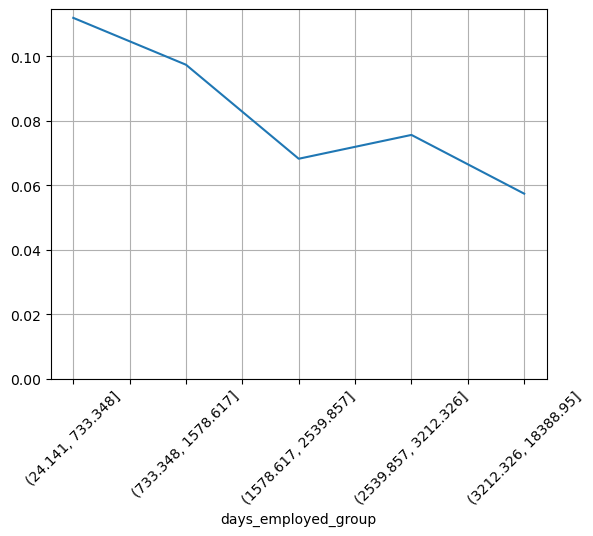

In [147]:
df.groupby('days_employed_group')['debt'].agg('mean').plot(grid=True, ylim=0)
plt.xticks(rotation=45)

Как и ожидалось, люди из группы с наименьшим трудовым стажем имеюют наиболее частые просрочки, далее процент понижается. Произошел рост просрочек для категории 6.5-8 лет стажа

In [148]:
df.groupby('family_status')['debt'].agg(['count', 'mean'])

,count,mean
family_status,,
Не женат / не замужем,2794,0.097709
в разводе,1185,0.071730
вдовец / вдова,954,0.064990
гражданский брак,4141,0.093214
женат / замужем,12295,0.075397


Наиболее надежная категория граждан по семеному статусу - вдовец / вдова. Самая рисковая - Не женат / не замужем и гражданский брак. В разводе и люди в браке являются достаточно надежными заемщиками

In [149]:
df.purpose.unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

In [150]:
categories = {
    'Недвижимость': ['жиль', 'недвижим'],
    'Автомобиль': ['авто'],
    'Образование': ['образован'],
    'Свадьба': ['свад']
}

In [151]:
def categorize_credit(goal):
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in goal:
                return category
    return 'Другое'

In [152]:
df['purpose_group'] = df['purpose'].apply(categorize_credit)

In [153]:
grouped = df.groupby('purpose_group').size().reset_index(name='Количество')
grouped

,purpose_group,Количество
0,Автомобиль,4286
1,Недвижимость,10766
2,Образование,3996
3,Свадьба,2321


Сгруппировали цели получения кредита на 4 категории для дальнейшего анализа

In [154]:
df.groupby('purpose_group')['debt'].agg(['count', 'mean'])

,count,mean
purpose_group,,
Автомобиль,4286,0.093327
Недвижимость,10766,0.072357
Образование,3996,0.092593
Свадьба,2321,0.079276


Изучив цели получения кредита, видим, что по займу на недвижимость, банк получает наиболее регулярные выплаты

In [155]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_group,total_income_group,days_employed_group,purpose_group
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,"(39.0, 47.0]","(200000.0, 300000.0]","(3212.326, 18388.95]",Недвижимость
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,"(31.0, 39.0]","(70000.0, 120000.0]","(3212.326, 18388.95]",Автомобиль
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,"(31.0, 39.0]","(120000.0, 150000.0]","(3212.326, 18388.95]",Недвижимость
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,"(31.0, 39.0]","(200000.0, 300000.0]","(3212.326, 18388.95]",Образование
4,0,2539.856894,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,"(47.0, 56.0]","(150000.0, 200000.0]","(1578.617, 2539.857]",Свадьба


# Результат исследования

На мой взгляд, в датасете не хватало крайне важного признака - размер кредита. По имеющимся данным получили следующие выводы.

**Влияние наличия детей:**
самыми ненадежными заемщиками являются многодетные семьи против семей без детей, у которых самая высокая доля погошения кредита. У семей без детей - 7,5%. У семей с детьми более 9%.

**Влияние возраста:** молодым людям выдавать кредит более рискованно, чем пожилым. Процент невыплат 11,2% против 5,4%.

**Влияние трудового стажа:** чем менбше стаж, тем больше проблем со своевременной выплатой. При стаже до 3 лет имеем 11,2% своевременно невыплаченных платежей, а при стаже более 8 лет показатель уменьшается до 6%.

**Влияние полученного образования:** люди с начальным образованием являются наиболее рискованной группой - 11% просрочек. Лидерами по возврату долгов являются граждане с высшим образованием - 5,3% просрочек.

**Влияние семейного положения:** наибольшую ответветственность можем наблюдать, у людей потерявших супруга (6,5% просрочек). У людей не вступивших в отношения, показатель самый худший - 9,8%.

**Влияние уровня заработной платы:** интересное наблюдение получилось по данному признаку. Оказывается, люди со средней заработной платой (и чуть выше) по стране, являются надежными заемщиками (категория 40000-70000 рублей, процент просрочек 6,8%), также, люди с самыми высокими доходами (200к+), возращают долги в срок с хорошим показателем (около 7%). Примечательно, что с ростом заработной платы от 70000 до 200000 рублей, своевременность выплат начинает страдать.

**Влияние целей получения кредита:** Наиболее надежная выдача средств - под ипотеку на покупку жилой недвижимости (просрочки в 7,2% случаях). А вот автокредитование является самой рисковой категорией - 9,3%, со схожим показателем - кредит на образование.

По результату исследования - женщины являются более надежными заемщиками, чем мужчины. 7% просрочек против 10,3%.



**Портрет идеального заемщика:**
  - женщина
  - пожилая возрастная группа 56+ лет
  - цель получения кредита: ипотека на недвижимость
  - вдова
  - рабочий стаж более 8 лет
  - без детей
  - заработная плата 40-70к или 200к+
  - с высшим образованием

**Портрет наиболее рискованного заемщика:**
  - молодой мужчина
  - возростная группа до 31 года
  - цель получения кредита: покупка автомобиля
  - семейное положение - не женат
  - стаж работы менее 3 лет
  - 2 или более детей
  - заработная плата 150-200к рублей
  - образование начальное
  


# ПРОГНОЗИРОВАНИЕ НАДЕЖНОСТИ ЗАЕМЩИКА

Для более качественной работы модели, обработаем выбросы и аномальные значения

In [156]:
anomals_columns = ['days_employed', 'dob_years', 
                   'total_income']

C:\Temp\ipykernel_29640\1262217354.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2, 2*index+1)
C:\Temp\ipykernel_29640\1262217354.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2, index)
C:\Temp\ipykernel_29640\1262217354.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[col]);
C:\Temp\ipykernel_29640\1262217354.py:3: MatplotlibDeprecationWa

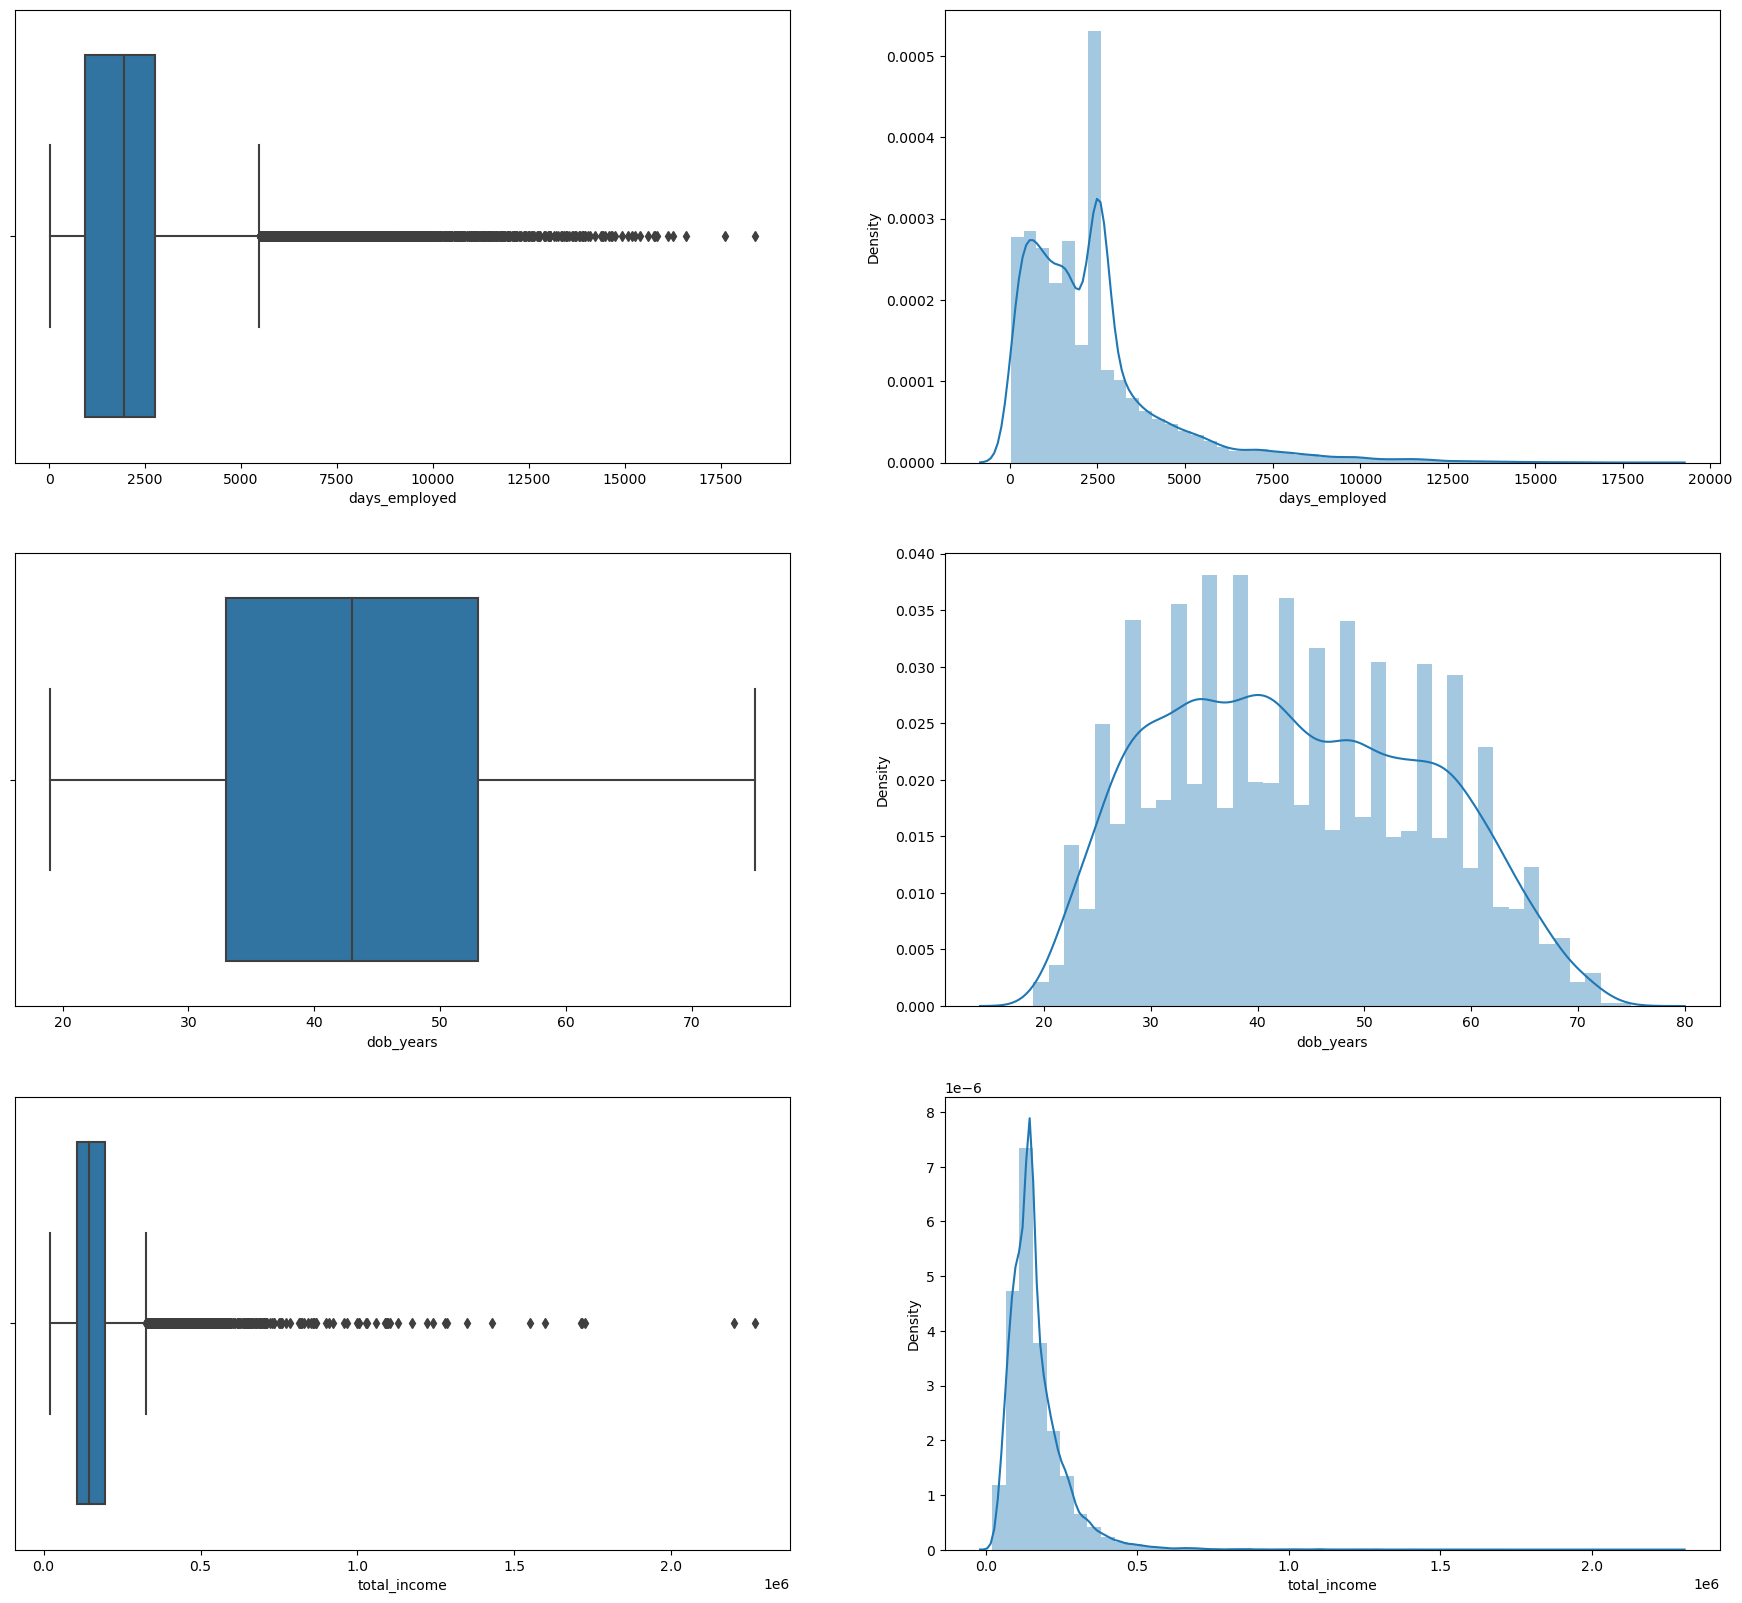

In [157]:
fig, ax = plt.subplots(6,2,  figsize = (22,20)) 
for index, col in enumerate(anomals_columns):
    plt.subplot(3,2, 2*index+1)
    ax = sns.boxplot(x = col, data = df)
    index = 2*(index+1)
    plt.subplot(3,2, index)
    ax = sns.distplot(df[col]);

Обработка total_income

In [158]:
a = df.total_income.quantile(.25)
b = df.total_income.quantile(.75)
a, b

(107706.0, 195737.0)

In [159]:
v = b+1.5*(b-a)
v

327783.5

Определили правую границу, значения выше которой, будем считать выбросами в признаке total_income

<Axes: xlabel='total_income'>

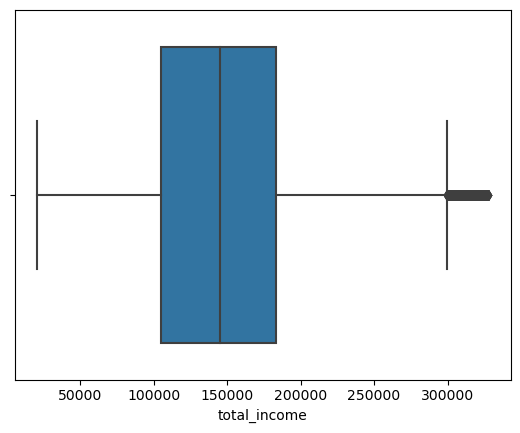

In [160]:
df[df.total_income > v].total_income.count()
df = df[df.total_income < v]
sns.boxplot(x=df['total_income'])

Обработка days_employed

In [161]:
a = df.days_employed.quantile(.25)
b = df.days_employed.quantile(.75)
a, b

(919.8703782397336, 2717.168751226509)

In [162]:
v = b+1.5*(b-a)
v

5413.116310706671

Определили правую границу, значения выше которой, будем считать выбросами в признаке days_employed

In [163]:
df = df[df.days_employed<v]

<Axes: xlabel='days_employed'>

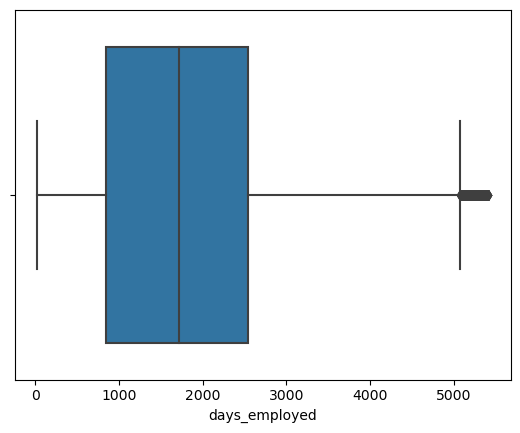

In [164]:
sns.boxplot(x=df.days_employed)

C:\Temp\ipykernel_29640\621126171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

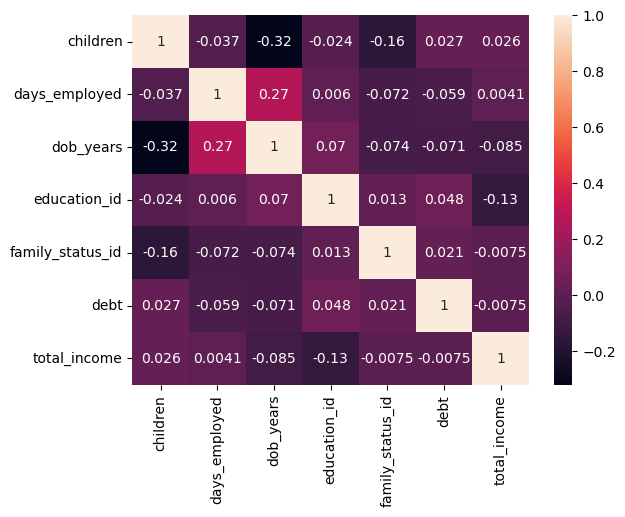

In [165]:
sns.heatmap(df.corr(), annot=True)

In [166]:
df.corr()

C:\Temp\ipykernel_29640\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
children,1.000000,-0.036649,-0.320036,-0.024438,-0.162937,0.027229,0.026097
days_employed,-0.036649,1.000000,0.270923,0.006049,-0.071969,-0.059150,0.004052
dob_years,-0.320036,0.270923,1.000000,0.070284,-0.074297,-0.070558,-0.084595
education_id,-0.024438,0.006049,0.070284,1.000000,0.012696,0.047509,-0.134838
family_status_id,-0.162937,-0.071969,-0.074297,0.012696,1.000000,0.021440,-0.007515
debt,0.027229,-0.059150,-0.070558,0.047509,0.021440,1.000000,-0.007499
total_income,0.026097,0.004052,-0.084595,-0.134838,-0.007515,-0.007499,1.000000


In [167]:
df.isnull().sum()

children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
dob_years_group        0
total_income_group     0
days_employed_group    0
purpose_group          0
dtype: int64

нет пропущенных значений

Преобразуем категориальные признаки в числа

In [168]:
from sklearn.preprocessing import LabelEncoder

{0: 'Автомобиль', 1: 'Недвижимость', 2: 'Образование', 3: 'Свадьба'}


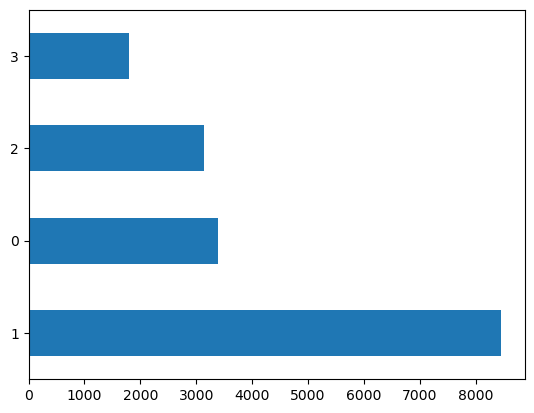

In [169]:
label_encoder = LabelEncoder()

le = pd.Series(label_encoder.fit_transform(df['purpose_group']))
le.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


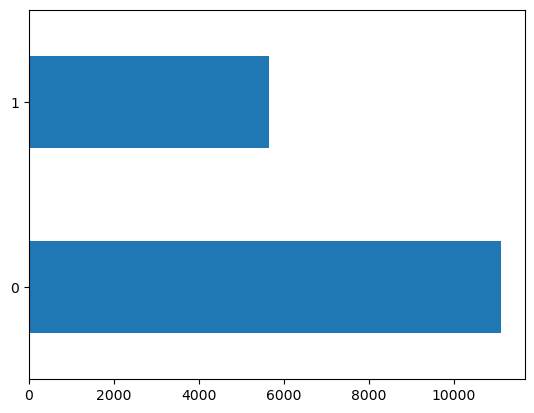

In [170]:
label_encoder = LabelEncoder()

le = pd.Series(label_encoder.fit_transform(df['gender']))
le.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [171]:
df['purpose_group'] = label_encoder.fit_transform(df['purpose_group'])
df['gender'] = label_encoder.fit_transform(df['gender'])

In [221]:
X = df.drop(['debt', 'education', 'family_status', 'income_type', 'purpose', 'dob_years_group', 'total_income_group', 'days_employed_group'], axis=1)
X.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,total_income,purpose_group
1,1,4024.803754,36,1,0,0,112080,0
3,3,4124.747207,32,1,0,1,267628,2
4,0,2539.856894,53,1,1,0,158616,3
5,0,926.185831,27,0,1,1,255763,1
6,0,2879.202052,43,0,0,0,240525,1


In [222]:
y = df.debt

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [177]:
X_train

,children,days_employed,dob_years,education_id,family_status_id,gender,total_income,purpose_group
4577,0,1597.434501,39,0,0,0,241411,2
8957,0,886.547288,64,1,0,1,112329,1
10044,0,392.417559,47,1,0,0,239025,1
11845,0,3448.392437,51,1,0,0,152886,1
18653,0,2539.856894,63,1,4,0,281513,2
...,...,...,...,...,...,...,...,...
14447,0,4279.952049,55,1,2,0,260733,1
15340,0,3562.050206,27,1,0,1,226409,0
6889,0,1482.366014,34,0,0,1,306853,1
1129,0,2539.856894,54,1,2,0,146645,0


Разбили датасет на тренировочные и тестовые выборки

In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [233]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 5, 7, 10],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 3, 5]
}

In [234]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)

rf = RandomForestClassifier(random_state=42, class_weight={0: class_weights[0], 1: class_weights[1]})

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_)

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

roc_auc_scores = cross_val_score(grid_search, X_test, y_test, cv=5, scoring='roc_auc')
f1_scores = cross_val_score(grid_search, X_test, y_test, cv=5, scoring='f1')

print("ROC AUC Scores:", roc_auc_scores)
print("Mean ROC AUC:", np.mean(roc_auc_scores))
print("F1 Scores:", f1_scores)
print("Mean F1:", np.mean(f1_scores))


Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.93      0.66      0.78      5068
           1       0.12      0.49      0.19       464

    accuracy                           0.65      5532
   macro avg       0.53      0.58      0.48      5532
weighted avg       0.87      0.65      0.73      5532

ROC AUC Scores: [0.62089881 0.61951496 0.61125795 0.59556412 0.59913922]
Mean ROC AUC: 0.609275013522588
F1 Scores: [0.1865285  0.17964072 0.18518519 0.19285714 0.19      ]
Mean F1: 0.18684230880290573


In [235]:
best_model = grid_search.best_estimator_

In [241]:
best_model.predict_proba(X)[:,1]

array([0.50554226, 0.39929126, 0.40212258, ..., 0.55685522, 0.39755496,
       0.52394097])

In [242]:
df['y_score'] = best_model.predict_proba(X)[:,1]

<Axes: >

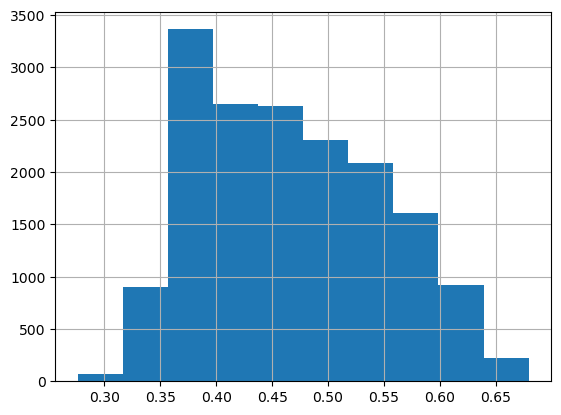

In [244]:
df['y_score'].hist()

In [245]:
thresholds = np.linspace(0, 1, num=101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [247]:
thresholds = np.linspace(0, 1, num=101)
f1_scores = []

for threshold in thresholds:
    y_pred = (df['y_score'] >= threshold).astype(int)
    f1 = f1_score(df['debt'], y_pred)
    f1_scores.append(f1)

results_df = pd.DataFrame({'threshold': thresholds, 'f1': f1_scores})

In [248]:
results_df

,threshold,f1
0,0.00,0.157009
1,0.01,0.157009
2,0.02,0.157009
3,0.03,0.157009
4,0.04,0.157009
...,...,...
96,0.96,0.000000
97,0.97,0.000000
98,0.98,0.000000
99,0.99,0.000000


In [250]:
max_f1_row = results_df.loc[results_df['f1'].idxmax()]
max_f1_row

threshold    0.510000
f1           0.229854
Name: 51, dtype: float64

In [251]:
unique_y_scores = sorted(df['y_score'].unique())

In [252]:
f1_scores = []

for threshold in unique_y_scores:
    y_pred = (df['y_score'] >= threshold).astype(int)
    f1 = f1_score(df['debt'], y_pred)
    f1_scores.append(f1)

results_df = pd.DataFrame({'threshold': unique_y_scores, 'f1': f1_scores})

In [253]:
max_f1_row = results_df.loc[results_df['f1'].idxmax()]
max_f1_row

threshold    0.508897
f1           0.230610
Name: 10880, dtype: float64

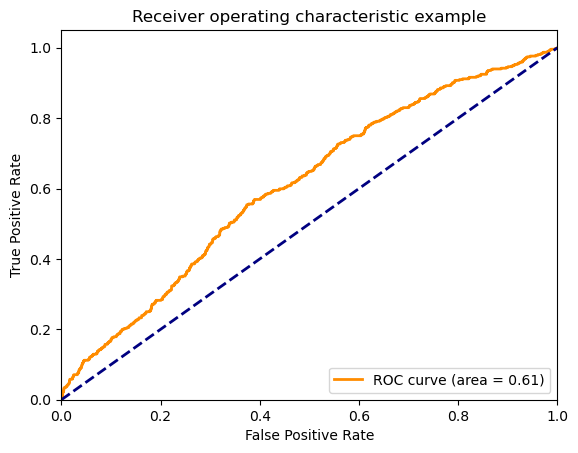

In [254]:
y_predicted_proba = best_model.predict_proba(X_test)
pd.Series(y_predicted_proba[:, 1]).unique()
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Полученная модель имеет место быть, в случае, когда мы хотим получить наибольшее количество клиентов. И наша модель рисков, допускает одобрение кредита для лиц с возможным риском